# Modelling Molecules with Brownian Motion

## Brandon Le

Brownian motion is a real-valued stochastic process $\{B(t):t\geq 0\}$ (think of collection of random variables ordered by time) with the following properties:

(i) $B(0) = \vec{0}$ (can loosen this definition to have $B(0) = \vec{x} \in \mathbb{R}^n$)

(ii) Independent increments, i.e. for all times $0 \leq t_1 \leq t_2 \leq \dots \leq t_n, B(t_n) - B(t_{n-1}), \dots, B(t_2) - B(t_1)$ are independent random variables.

(iii) For all $t > 0$ and $h > 0, B(t+h) - B(t)$ is normally distributed with mean $\vec{0}$ and covariance matrix $hI$.

(iv) the mapping $t \rightarrow B(t)$ is continuous almost everywhere.

We're modeling Brownian motion discretely; assuming the timesteps are equally sized, we're really modeling a summation of independent normally distributed displacements by property (ii) and (iii). Given an arbitrary particle starting at $\vec{x}$, we can approximated its motion by:

$$B(0) \sim \vec{x}$$
$$B(1) \sim B(0) + N(0,\sqrt{h})$$
$$B(2) \sim B(1) + N(0,\sqrt{h})$$
$$ \cdots $$


Due to the radial symmetry of the project, we'll be working with polar coordinates.

Given two points $(\theta_1, r_1)$ and $(\theta_2, r_2)$, we have for the sum of the points $(\theta, r)$:

$$\theta = \theta_1 + arctan2(r_2sin(\theta_2 - \theta_1),r_1 + r_2cos(\theta_2 - \theta_1))$$

$$ r = \sqrt{r_1^2 + r_2^2 + 2r_1r_2cos(\theta_1 - \theta_2)}$$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random

# adding two vectors in polar co-ordinates
def add_vectors(a,b):
    #input: a and b are numpy matrices where each row is a point in polar coordinates (theta,r)
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    ang_a, ang_b = a[:,0], b[:,0]
    len_a, len_b = a[:,1], b[:,1]
    c = a.copy()
    angle_sum = ang_a + np.arctan2(len_b*np.sin(ang_b - ang_a), len_a + len_b*np.cos(ang_b - ang_a))
    length_sum = np.sqrt(np.maximum(len_a**2 + len_b**2 + 2*len_a*len_b*np.cos(ang_a - ang_b),0)) 
    c[:,0], c[:,1] = angle_sum, length_sum
    return c

#subtracting two vectors in polar co-ordinates
def subtract_vectors(a,b):
    #input: a and b are numpy matrices where each row is a point in polar coordinates (theta,r)
    #remark: a - b = a + (-b), where -b has the same radius but rotated 180deg/pi radians
    c = b.copy()
    c[:,0] = b[:,0] + np.pi
    return add_vectors(a,c)

# the brownian motion simulation, where we add a random distance picked from a normal distribution
def gen_normal(points, length = 1):
    #input: points is a matrix of points, where each row is point (theta,r). length is about how far you want particle to move.
    #adds a vector in a random direction to each of the points, simulating movement
    update = np.zeros(np.shape(points))
    angles = np.random.uniform(0, 2*np.pi, size = (points.shape[0],1))
    #choose either fixed movement or normally dist. movement (they both converge to brownian motion distribution)
    lengths = np.tile(length, (points.shape[0],1))
    #normal dist is great with no collisions, too erratic with collisin code later on. use the uniform movement above.
    #lengths = np.absolute(np.random.normal(0, length, size = (points.shape[0],1)))
    b = np.concatenate(((angles,lengths)), axis = 1)
    update = add_vectors(points, b)
    return update

# we will detect collisions between particles using a distance matrix
def distance_matrix(xpoints,ypoints):
    #creates a matrix whose i,jth entry is the distance between xpoint i and ypoint j
    #currently only works if both xpoints,ypoints have the same number of points, and using polar co-ords
    angles_x = np.tile(xpoints[:,0], [len(xpoints),1])
    angles_y = np.tile(ypoints[:,0], [len(ypoints),1]).T
    lengths_x = np.tile(xpoints[:,1], [len(xpoints),1])
    lengths_y = np.tile(ypoints[:,1], [len(ypoints),1]).T
    return np.sqrt(np.maximum(lengths_x**2 + lengths_y**2 - 2*lengths_x*lengths_y*np.cos(angles_x - angles_y),0)).T

<IPython.core.display.Javascript object>


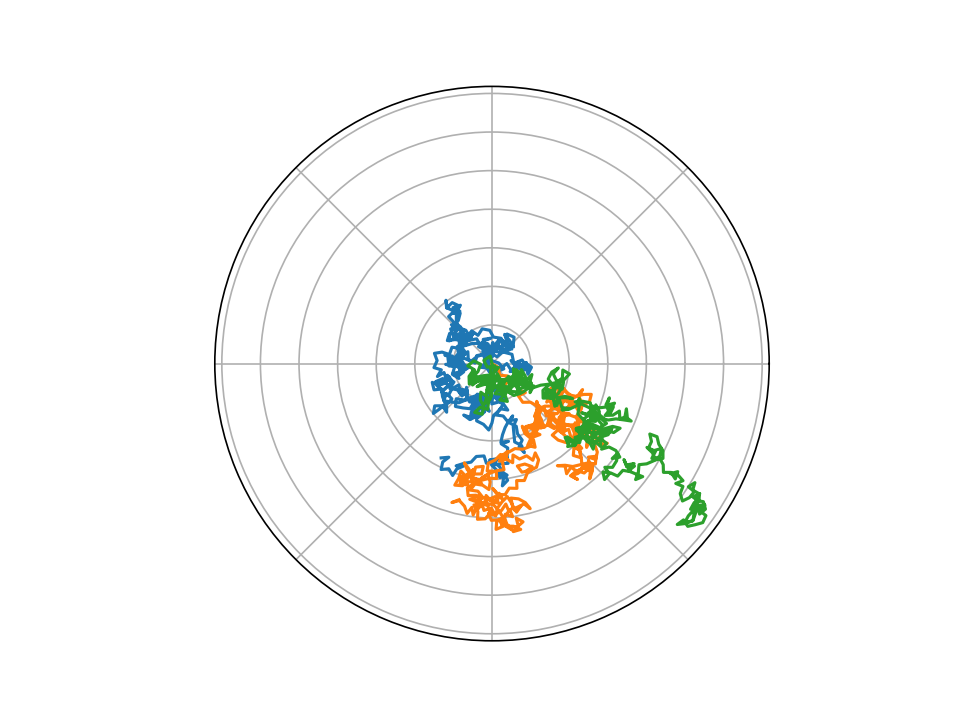

In [57]:
#example brownian motion of n particles starting at the origin in polar, input (n,2)
start = np.zeros((3,2))
m = 400 #iterations
storage = [0]*m
storage[0] = start
fig = plt.figure()
ax = fig.add_subplot(polar = True)
#hide angles
ax.set_xticklabels([])
#hide radii
ax.set_yticklabels([])
for i in range(m-1):
    storage[i+1] = gen_normal(storage[i])
    
for j in range(start.shape[0]):
    theta,r = [e[j,0] for e in storage],[e[j,1] for e in storage]
    #plt.polar(theta,r,c=np.random.rand(3,))
    ax.plot(theta,r)
plt.show()

## Implementing Collision

Not only do we want to simulate random movement in our particles, we also want to simulate collision, that is the particles don't intersect with each other. For our SRI project we have 3 particles we want to consider with collision:

1) NOG

2) BMP4

3) Stem cells

where NOG and BMP4 are simulated by brownian motion, and Stem cell motion is provided by Jaxon Green. We want both NOG and BMP4 to bounce off of stemcells (as cells are significantly larger than these morphogens, this is a valid assumption of elastic collision) We also want NOG, BMP4 to bounce off each other respectively, but only BMP4 bounces off of NOG morphogens if they collide. NOG is an inhibitor for the movement of BMP4 cells, and this assumption helps simulate that particular movement.

In [58]:
#This code chunk generates the nog, bmp4, and stem cells used for animation testing
#there needs to be a numpy matrix for each type of particle, with each row a particle in polar co-ords (theta,r)

#assume the particles have radius r
r1 = 0.13
r2 = 0.13
r3 = 0.3

#and non-stemcells behave with brownian motion with standard deviation jitter
jitter = .05
jitter2 = .10

#starting positions should not overlap with any other particle for realistic simulation

#creates nog points,
particles_nog = 50  #this has to be a multiple of 10 for spider web points to work
#nog = np.zeros((particles_nog,2))
#nog = np.concatenate((np.random.uniform(0, 2*np.pi,(particles_nog,1)), abs(np.random.normal(0,1,(particles_nog,1)))), axis = 1)
#creates spider-web of points
grid_len = np.linspace(1, 2.5, num=round(particles_nog/10))
grid_ang = np.linspace(0,np.pi*7/4, num = 10)
len_rep = np.array([np.repeat(grid_len,len(grid_ang))])
ang_rep = np.array([np.tile(grid_ang, len(grid_len))])
nog = np.concatenate((ang_rep,len_rep), axis = 0).T

#creates bmp4 points
bmp4 = np.array([[0,.25],[np.pi,.25],[3*np.pi/2,.25],[np.pi/2,1.5]])

#creates stem cell points
stemcells = np.array([[np.pi/2,2],[5*np.pi/4,2]])

In [59]:
# simulates 1 particle bouncing off when collision occurs
# function is ran twice if we want both particles to bounce off
def bounce_off(start,end,position,scalar = 1):
    #input: particles before and after brownian movement + collision positions
    #computes where the particles would go after collision
    #figure out how much particle moves
    diff = subtract_vectors(end[position], start[position])
    #this describes bouncing backwards, with some random jitter
    diff[:,0] += np.pi + np.random.uniform(0, np.minimum(np.pi/6 + scalar*np.pi/6, 3*np.pi/4))
    #now we replace the collided particles by moving back from the collision spot
    where_collided = end[position].copy()
    end[position] = add_vectors(where_collided, diff)

In [60]:
#the function that updates every non-step particle in a single time-step
def gen_update(nog,r1,jitter,bmp4,r2,jitter2,stemcells,r3):
    #these code chunks needs to be converted to functions for visual clarity
    #couldnt figure out how to input dist[something:something,something:something] into function bcs of those pesky colons ":"
    
    #inputs a matrix, where each row is a particle in polar coords
    #applys gen_normal, then checks if there are collisions. If so, simulates bounces for those particles
    #returns the positions of nog,bmp4 respectively
    
    #compute number of particles you've inputted
    num_nog = nog.shape[0]
    num_bmp4 = bmp4.shape[0]
    num_cells = stemcells.shape[0]
    
    #apply random movement to nog and bmp4. end,end2 are final positions of nog and bmp4, respectively. 
    #everything afterwards is just modifying end,end2 when there are collisions
    end = gen_normal(nog, jitter)
    end2 = gen_normal(bmp4, jitter2)
    
    #concatenate nog, bmp4, and stem cells in that order
    particles = np.concatenate((end,end2,stemcells), axis = 0)
    dist = distance_matrix(particles,particles)
    #find position entries where collision (of nog with nog particles) occurs
    nognog = np.asarray(dist[:num_nog,:num_nog] < r1 + r1).nonzero()
    #look only at top-right entries due to symmetry of dist. matrix 
    alpha = nognog[0][nognog[0] < nognog[1]]
    beta = nognog[1][nognog[0] < nognog[1]]
    
    scalar = 1.0
    while len(alpha) != 0 and scalar < 10:
        bounce_off(nog,end,alpha,scalar)
        bounce_off(nog,end,beta,scalar)
        #updates everything and runs loop until after no more intersections or after scalar tries
        particles[:num_nog,:] = end
        dist = distance_matrix(particles,particles)
        nognog = np.asarray(dist[:num_nog,:num_nog] < r1 + r1).nonzero()
        alpha = nognog[0][nognog[0] < nognog[1]]
        beta = nognog[1][nognog[0] < nognog[1]]
        scalar = scalar + 1
        
    bmp4bmp4 = np.asarray(dist[num_nog:-num_cells,num_nog:-num_cells] < r2 + r2).nonzero()
    #look only at top-right entries due to symmetry of dist. matrix
    gamma = bmp4bmp4[0][bmp4bmp4[0] < bmp4bmp4[1]]
    delta = bmp4bmp4[1][bmp4bmp4[0] < bmp4bmp4[1]]
    
    scalar = 1.0
    while len(gamma) != 0 and scalar < 10:
        bounce_off(bmp4,end2,gamma,scalar)
        bounce_off(bmp4,end2,delta,scalar)
        #updates everything and runs loop until after no more intersections or after scalar tries
        particles[num_nog:-num_cells,:] = end2
        dist = distance_matrix(particles,particles)
        bmp4bmp4 = np.asarray(dist[num_nog:-num_cells,num_nog:-num_cells] < r2 + r2).nonzero()
        gamma = bmp4bmp4[0][bmp4bmp4[0] < bmp4bmp4[1]]
        delta = bmp4bmp4[1][bmp4bmp4[0] < bmp4bmp4[1]]
        scalar = scalar + 1
        
    nogbmp4 = np.array(dist[:num_nog,num_nog:-num_cells] < r1 + r2).nonzero()
    #look only ALL entries as we're no longer on diagonal of dist. matrix
    epsilon = nogbmp4[1]
    scalar = 1.0
    
    while len(epsilon) != 0 and scalar < 10:
        bounce_off(bmp4,end2,epsilon,scalar)
        #updates everything and runs loop until after no more intersections or after scalar tries
        particles[num_nog:-num_cells,:] = end2
        dist = distance_matrix(particles,particles)
        nogbmp4 = np.array(dist[:num_nog,num_nog:-num_cells] < r1 + r2).nonzero()
        epsilon = nogbmp4[1]
        scalar = scalar + 1
        
    nogstem = np.array(dist[:num_nog,-num_cells:] < r1 + r3).nonzero()
    #look only ALL entries as we're no longer on diagonal of dist. matrix
    zeta = nogstem[0]
    scalar = 1.0
    
    while len(zeta) != 0 and scalar < 10:
        bounce_off(nog,end,zeta,scalar)
        #updates everything and runs loop until after no more intersections or after scalar tries
        particles[:num_nog,:] = end
        dist = distance_matrix(particles,particles)
        nogstem = np.array(dist[:num_nog,-num_cells:] < r1 + r3).nonzero()
        zeta = nogstem[0]
        scalar = scalar + 1
        
    bmp4stem = np.array(dist[num_nog:-num_cells,-num_cells:] < r2 + r3).nonzero()
    #look only ALL entries as we're no longer on diagonal of dist. matrix
    eta = bmp4stem[0]
    scalar = 1.0
    
    while len(eta) != 0 and scalar < 10:
        bounce_off(bmp4,end2,eta,scalar)
        #updates everything and runs loop until after no more intersections or after scalar tries
        particles[num_nog:-num_cells,:] = end2
        dist = distance_matrix(particles,particles)
        bmp4stem = np.array(dist[num_nog:-num_cells,-num_cells:] < r2 + r3).nonzero()
        eta = bmp4stem[0]
        scalar = scalar + 1
    
    return end,end2

<IPython.core.display.Javascript object>


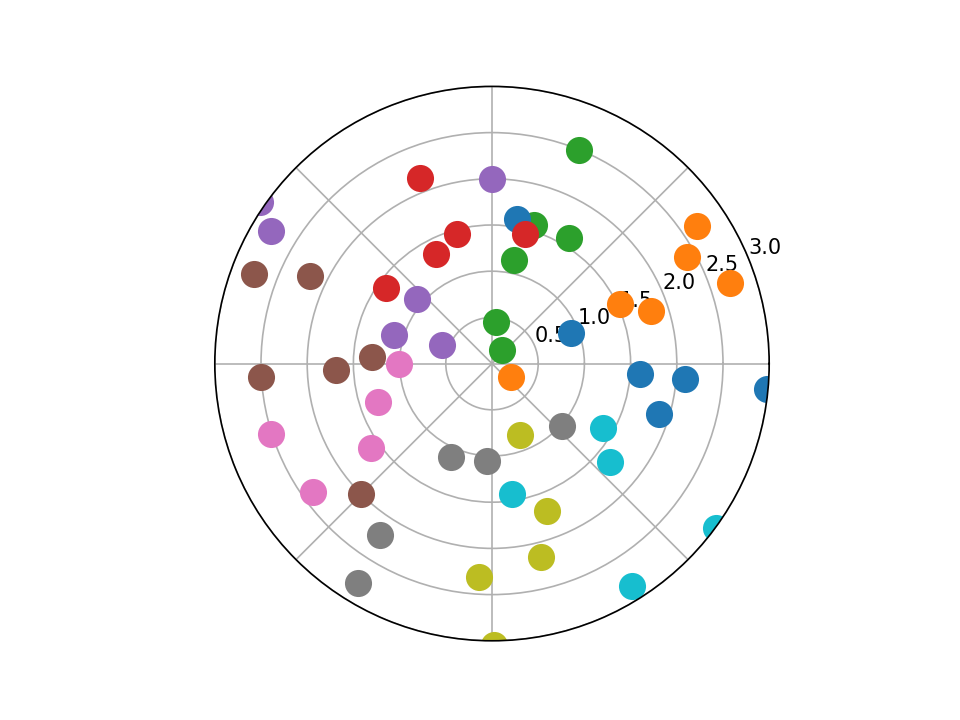

In [61]:
#remove below line if running as .py file
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(polar = True)
ax.set_ylim(0,3)
#hide angles
ax.set_xticklabels([])
#hide radii
#ax.set_yticklabels([])

steps = 300
storage = [0]*steps
storage[0] = np.concatenate((nog,bmp4,stemcells),axis = 0)

num_nog = nog.shape[0]
num_bmp4 = bmp4.shape[0]
num_cells = stemcells.shape[0]
size = num_nog + num_bmp4 + num_cells

for i in range(steps-1):
    positions = gen_update(
        storage[i][:num_nog],
        r1 = r1,
        jitter = jitter,
        bmp4 = storage[i][num_nog:-num_cells],
        r2 = r2,
        jitter2 = jitter2,
        stemcells = storage[i][-num_cells:],
        r3 = r3)
    storage[i+1] = np.concatenate((positions[0],positions[1],stemcells),axis = 0)

# creates the first plot in animation
# couldnt figure out to create particles of different size
pnt = ax.plot(np.zeros((1,size)), np.zeros((1,size)), 'o', markersize = 12)

# function that updates first plot along the animation
def update_point(n, storage, pnt):
    for point_i, index in zip(pnt,range(size)):
        point_i.set_data((storage[n][index,0], storage[n][index,1]))
    return pnt

ani = animation.FuncAnimation(fig, update_point, steps - 1, fargs=(storage, pnt), interval = 100)

plt.show()